In [1]:
# Ensure you run this at the beginning of the notebook
%matplotlib notebook

from pynq import Overlay
from pynq import allocate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output


ol = Overlay("dma.bit")
ol.download()


In [2]:


dma = ol.axi_dma
dma.register_map



RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [3]:
data_size = 1024
output_buffer = allocate(shape=(data_size,), dtype=np.uint32)

# Test a single DMA transfer
try:
    dma.recvchannel.transfer(output_buffer)
    dma.recvchannel.wait()  # Check if this runs without errors
    print("DMA transfer completed successfully.")
except RuntimeError as e:
    print(f"Error: {e}")


DMA transfer completed successfully.


In [4]:

def read_adc_data():
    """
    This function reads the data from DMA and returns the processed data.
    It will be used by FuncAnimation to update the plot.
    """
    if dma.recvchannel.running:
        dma.recvchannel.transfer(output_buffer)
        dma.recvchannel.wait()

        processed_data = output_buffer & 0x0FFF  # Keep only lower 12 bits
        return processed_data
    else:
        return None

def display_adc_data():
    """
    This function sets up the real-time display using FuncAnimation.
    It continuously updates the plot with the latest data from the ADC.
    """
    # Initialize the plot
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get current axis
    line, = ax.plot([], [], label="ADC Data")

    ax.set_title("ADC Channel 1 - Real-Time")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Value")
    ax.set_xlim(0, len(output_buffer)-1)
    ax.set_ylim(0, 4096)  # Assuming 12-bit data
    ax.grid(True)
    ax.legend()

    # Define the update function for FuncAnimation
    def update(frame):
        # Read new ADC data
        processed_data = read_adc_data()

        if processed_data is not None:
            # Update the plot data
            line.set_ydata(processed_data)

        return line,  # FuncAnimation requires the return to be a tuple

    # Create FuncAnimation to update the plot in real-time
    ani = FuncAnimation(plt.gcf(), update, frames=100, interval=100, blit=True)

    # Show the plot and start animation
    plt.show()

<IPython.core.display.Javascript object>


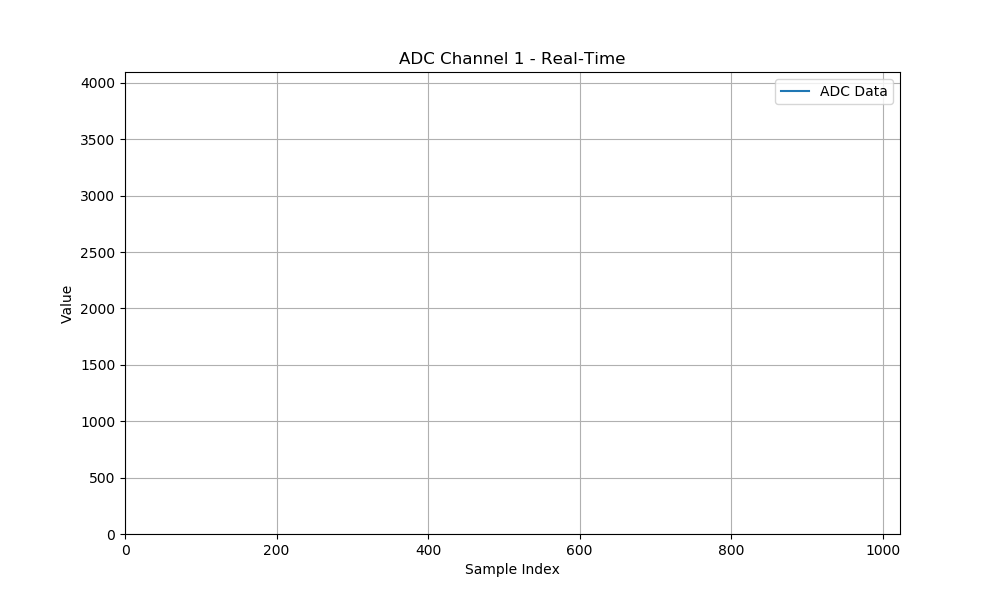

In [5]:
display_adc_data()